In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Definition of the Lotka-Volterra model, with VP = f(x(t), t; theta)
def VP(z, t, alpha, beta, gamma, sigma):
    x, y = z
    dzdt = [alpha * x - beta * x * y, - gamma * y + sigma * x*y]
    return dzdt

# Function to plot the trajectories in the 2D state space
def plot_traj(trajectories, width = 1.):
    x = trajectories[:,0]
    y = trajectories[:,1]
    plt.plot(x, y, linewidth = width)

In [3]:
# Data of the problem
data_size = 16001  # Size of the dataset (fictitious and created by adding noise to the real
                   #  data found through the integration of the system)
batch_time = 320  #
niters = 1000  # Number of Hamiltonian MC iterations
batch_size = 1000

# Parameters of the true model
alpha = 1.
beta = 0.1
gamma = 1.5
sigma = 0.75

In [4]:
t_grid = np.linspace(0, 25, data_size)
z0 = [5., 5.]
true_yy = odeint(VP, z0, t_grid, args=(alpha, beta, gamma, sigma))

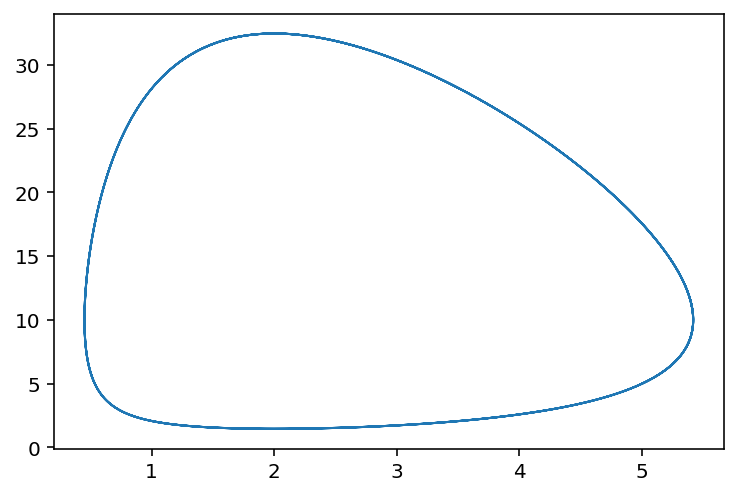

In [5]:
plot_traj(true_yy)

In [6]:
true_y = true_yy.copy()

sigma_x = np.std(true_yy[:, 0:1])  # Standard deviation of data for x = preys
sigma_y = np.std(true_yy[:, 1:2])  # Standard deviation of data for y = predators

noise_level = 0.03  # Adding some nois with this noise level
sigma_normal = max(sigma_x, sigma_y)  # Considering the highest between the 2

true_y[:, 0:1] = true_y[:, 0:1]/sigma_x + noise_level * np.random.randn(true_y[:, 0:1].shape[0], true_y[:, 0:1].shape[1])
true_y[:, 1:2] = true_y[:, 1:2]/sigma_y + noise_level * np.random.randn(true_y[:, 1:2].shape[0], true_y[:, 1:2].shape[1])
# The 2 lines above normalize the data and then add a noise being extract from a gaussian
#  random variable with 0 mean and (noise_level)^2 variance.

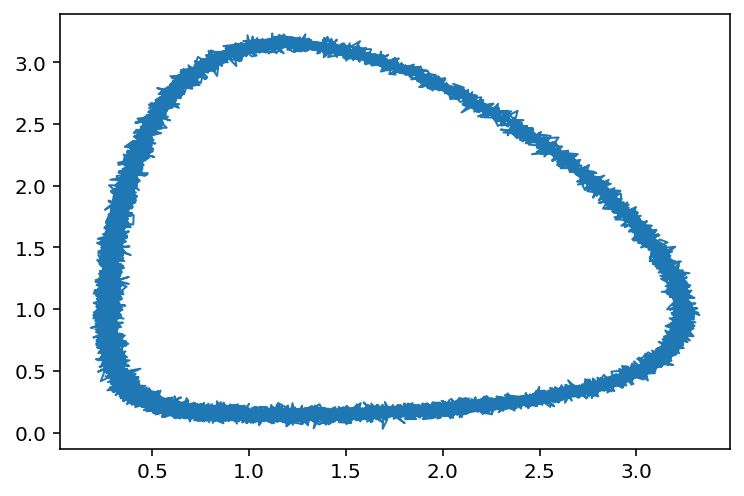

In [7]:
plot_traj(true_y)

In [8]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    #  being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [9]:
num_param = 4  # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 20)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch

In [10]:
from neural_ode import NeuralODE

In [11]:
#########################################
#         precondition start            #
#########################################
niters_pre = 1000  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]  # preys
        h2 = h[:, 1:2]  # predators

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # Why sigma_y?? Think it's due to normalization, but boh
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # Why sigma_x??
        h_out = tf.concat([h_out1, h_out2], 1)
        # This function is computing the f(x(t), t; p) at [x,t] in 'inputs' and with p
        #  the actual weights of the model
        return h_out
    
model_pre = ODEModel_pre()
neural_ode_pre = NeuralODE(model_pre, t_in)
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)

In [12]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros((para_num, 1))

from tqdm import tqdm

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()

print(parameters_pre)

#########################################
#          precondition end             #
#########################################

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.31it/s]

[[ 0.9977199 ]
 [-0.10009171]
 [-1.5038252 ]
 [ 0.75141925]]


In [13]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]
        h2 = h[:, 1:2]

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]  
        p4 = self.Weights[3] 

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # ?? As before, why sigma_y?
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # ?? As before, why sigma_x?
        h_out = tf.concat([h_out1, h_out2], 1)
        return h_out
    
model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

temp_model = ODEModel()
neural_ode_temp = NeuralODE(temp_model, t=t_in)

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(4, 1) here


In [14]:
# non c'è nel codice

@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

In [15]:
w_temp = np.resize([1,-0.1, -1.5, 0.75],(4,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0026071602>

In [16]:
##################################################################################################################
############################################   LIBRARY OF FUNCTIONS   ############################################
##################################################################################################################

In [17]:
def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [18]:
def border_estimates_e_abc(eps, niters):
    
    # This function estimates the borders of the region containing the eps-approximate posterior through niters 
    #  iterations. It uses the empirical sampling method to get nearer to the correct acceptance region.
    #  This is only used to estimate borders, though it can estimate also the parameters in order to avoid 
    #  biases in the estimation.

    import scipy.stats as sps

    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    initial_loss = 0

    naccepted = 0
    
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        lambda_temp = npr.uniform(low = 0, high = 1.5)

        WW = model.trainable_weights[0].numpy()

        w_temp_1 = 0
        w_temp_2 = 0
        w_temp_3 = 0
        w_temp_4 = 0

        alpha_quant = 0.25 # crasha ogni volta, ogni volta dopo un numero differente di iterazioni.
        # trovato su stackoverflow:
                #I've encountered the same problem as well. 
                #The thing is that the lower bound a is above (or close to) the 99% quantile of the Normal distribution.
                #Thus the truncation causes scipy to crush.
                #The only solution I came out with is to check before truncation if myclip_a is above the 99% quantile and
                #if so avoid the update. I hope that someone will find a better solution than mine!

        w_temp_1 = adaptive_gaussian_sampling(WW[0], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
        w_temp_2 = adaptive_gaussian_sampling(WW[1], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
        w_temp_3 = adaptive_gaussian_sampling(WW[2], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
        w_temp_4 = adaptive_gaussian_sampling(WW[3], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)

        w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]
    
    border1 = np.min(parameters[:,0])
    border2 = np.max(parameters[:,1])
    border3 = np.max(parameters[:,2])
    border4 = np.min(parameters[:,3])

    return([border1, border2, border3, border4])

In [19]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.25) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.75)):
        a = 0
        b = 0
        if true_center > loc:
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [20]:
def preprocessing_e_abc(eps, niters, borders):

    # This function performs the first sampling from the region defined through the borders estimating function and
    #  returns the estimated parameters and the initializing weights, ([1,1,1,...,1] normalized)
    
    import scipy.stats as sps

    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    initial_loss = 0

    niters = 50000
    naccepted = 0
    eps = 0.05 # To be determined, it is a hyperparameter

    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        # We will consider here the standard Ridge model for data approximation

        lambda_temp = npr.uniform(low = 0, high = 1.5)

        WW = model.trainable_weights[0].numpy()

        w_temp_1 = 0
        w_temp_2 = 0
        w_temp_3 = 0
        w_temp_4 = 0

        # alpha_quant = 0.15

        w_temp_1 = e_abc_gaussian_sampling(WW[0], 0, 1/lambda_temp, borders[0])
        w_temp_2 = e_abc_gaussian_sampling(WW[1], 0, 1/lambda_temp, borders[1])
        w_temp_3 = e_abc_gaussian_sampling(WW[2], 0, 1/lambda_temp, borders[2])
        w_temp_4 = e_abc_gaussian_sampling(WW[3], 0, 1/lambda_temp, borders[3])

        w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]

    weights = np.ones(parameters.shape[0])/parameters.shape[0]
    
    return(parameters, weights)

In [21]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    
    # This function computes the weights associated to each parameter as described in https://arxiv.org/pdf/1106.6280.pdf
    
    prob_w = 1
    for i in range(4):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(4):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)

In [22]:
def normalize_weights(weights):
    
    # This function performs the normalization of weights
    
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

In [23]:
def sample_abc_smc_element(parameters, weights):
    
    # This function samples from the previous population according to the specified weights
    
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

In [24]:
def perturbation_kernel(sdev):
    
    # This function returns the perturbation from a Gaussian kernel with the specified standard deviation
    
    return([np.random.randn()*sdev[0], np.random.randn()*sdev[1], np.random.randn()*sdev[2], np.random.randn()*sdev[3]])

In [25]:
def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    # This function returns the sampling according to the ABC-SMC with the weights associated to old parameters
    # specified in weights and the old parameters specified in old_parameters
    
    import scipy.stats as sps

    # We now start the Bayesian framework
    # We will compute the Approximate Bayesian Computation approximation from the posterior
    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    print(initial_loss)
    initial_loss = 0
    # In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
    # loss con i theta individuati e meglio è per la simulazione.
    # In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
    # si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
    # sbatti...

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        # Pipeline to accept/reject the new point
        w_temp = np.resize(w_temp, (4,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5)
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        

    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)

In [26]:
###################################################################################################################

In [27]:
import scipy.stats as sps

eps = 0.05
niters = 1000
std_dev_start = [0.05, 0.05, 0.05, 0.05]

print("Borders estimation start...")
borders = border_estimates_e_abc(eps, 50*niters)
print("Borders estimation completed, starting preprocessing...")
start, start_weights = preprocessing_e_abc(eps, 50*niters, borders)
print("Preprocessing completed, starting ABC-SMC")
parameters, weights = sample_abc_smc(eps, 5*niters, std_dev_start, start, start_weights)
parameters, weights = sample_abc_smc(0.007, 5*niters, std_dev_start, parameters, weights)
parameters, weights = sample_abc_smc(0.0035, 5*niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(0.003, 5*niters, np.std(parameters, axis=0), parameters, weights)
parameters, weights = sample_abc_smc(0.0025, 25*niters, np.std(parameters, axis=0), parameters, weights)

Borders estimation start...


  0%|                                                                              | 12/50000 [00:00<07:11, 115.73it/s]

Acceptance rate:  0.00134
Borders estimation completed, starting preprocessing...


  0%|                                                                                 | 4/5000 [00:00<02:24, 34.58it/s]

Acceptance rate:  0.00184
Preprocessing completed, starting ABC-SMC
tf.Tensor(5.2061787, shape=(), dtype=float32)


  0%|▎                                                                              | 16/5000 [00:00<00:32, 154.22it/s]

Acceptance rate:  0.3358
tf.Tensor(5.2061787, shape=(), dtype=float32)


  0%|▏                                                                              | 14/5000 [00:00<00:36, 137.60it/s]

Acceptance rate:  0.006
tf.Tensor(5.2061787, shape=(), dtype=float32)


  0%|                                                                                 | 5/5000 [00:00<01:48, 45.98it/s]

Acceptance rate:  0.0216
tf.Tensor(5.2061787, shape=(), dtype=float32)


  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]

Acceptance rate:  0.0868
tf.Tensor(5.2061787, shape=(), dtype=float32)


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:17<00:00, 78.74it/s]

Acceptance rate:  0.04352


In [28]:
###################################################################################################################

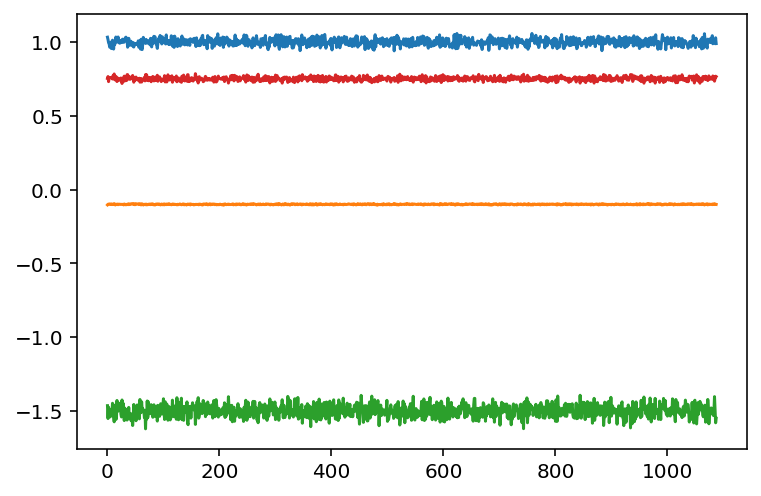

In [29]:
plt.plot(parameters)

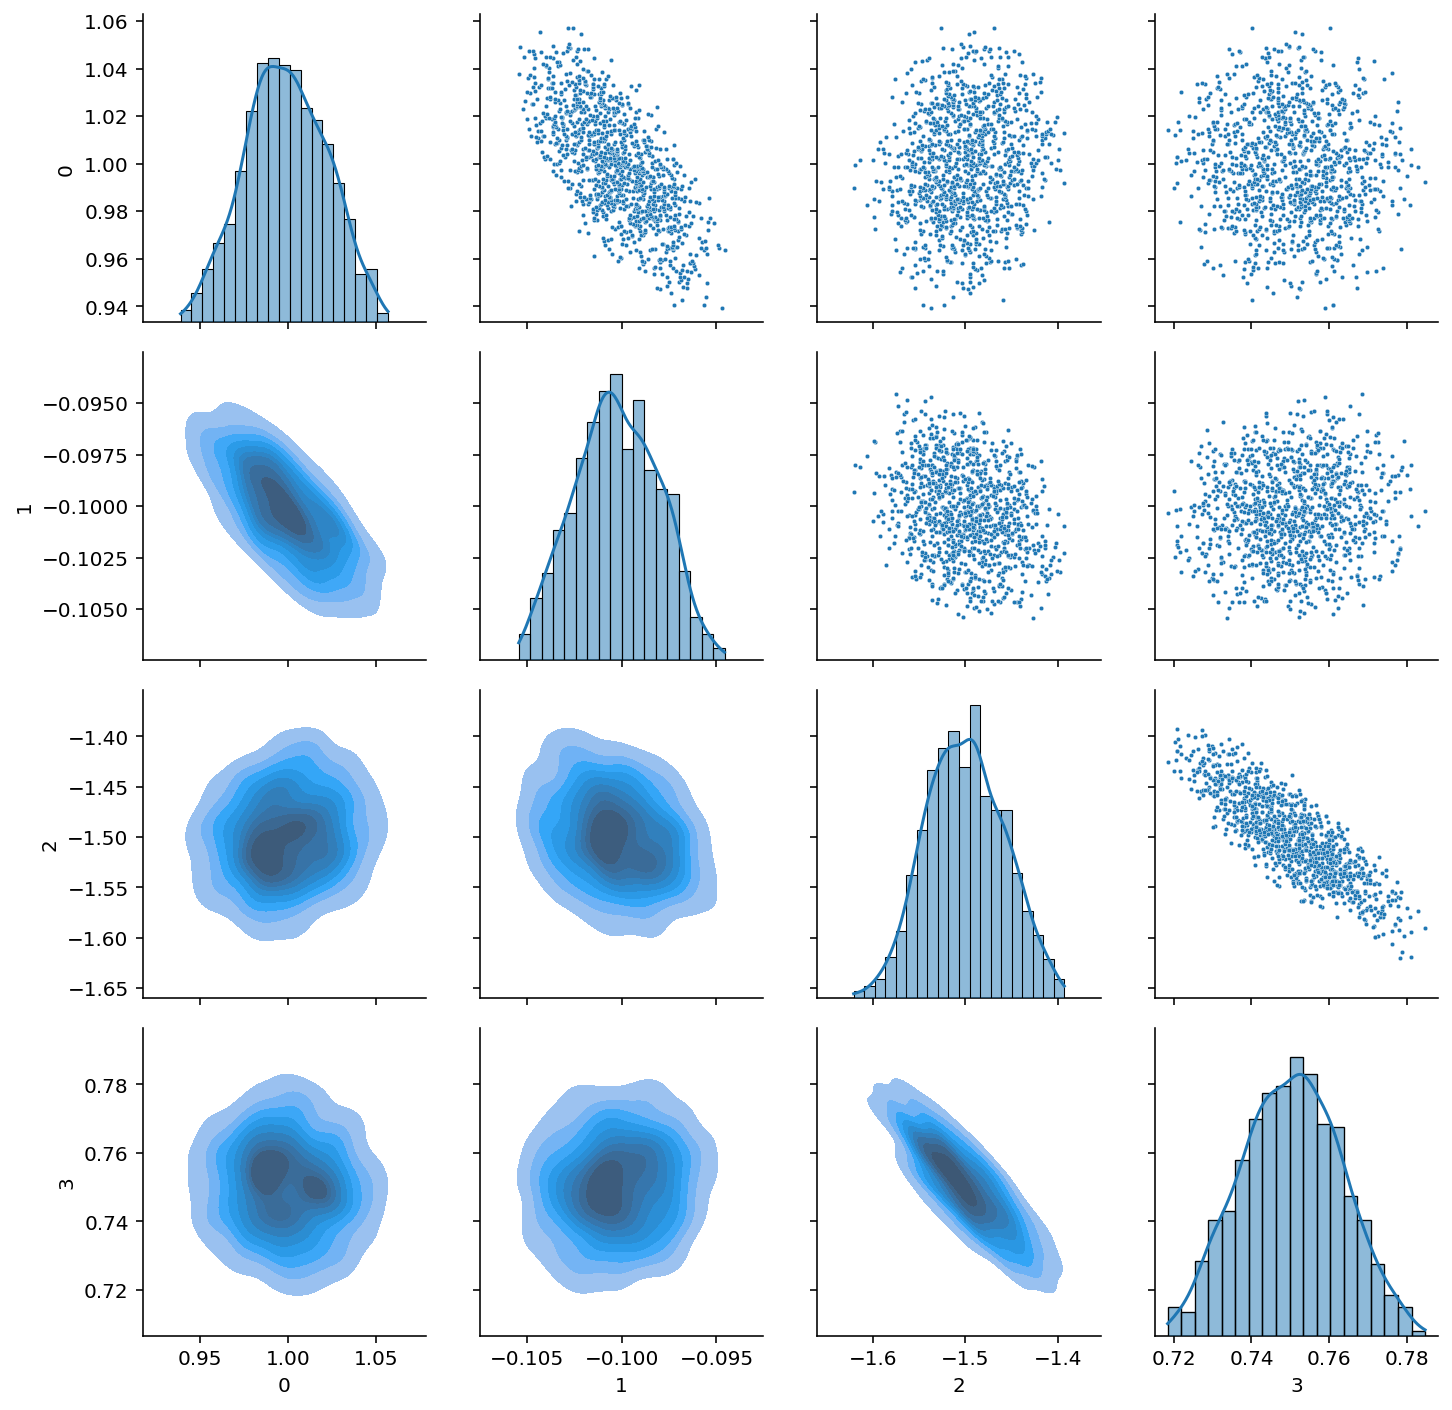

In [30]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [32]:
import arviz as az

az.ess(parameters[:,1])

1037.9269438327108

<AxesSubplot:title={'center':'x'}>

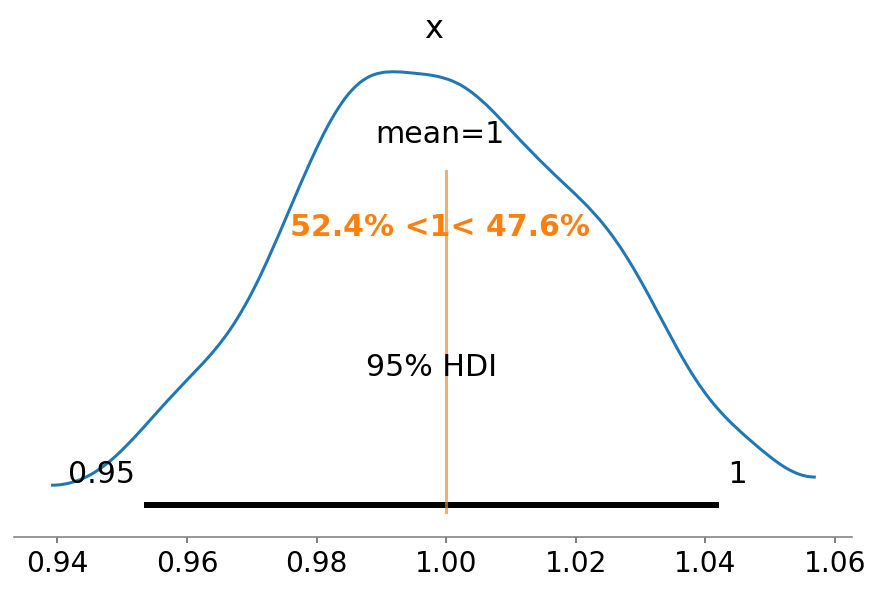

In [33]:
az.plot_posterior(parameters[:,0],hdi_prob = 0.95, ref_val = 1)

<AxesSubplot:title={'center':'x'}>

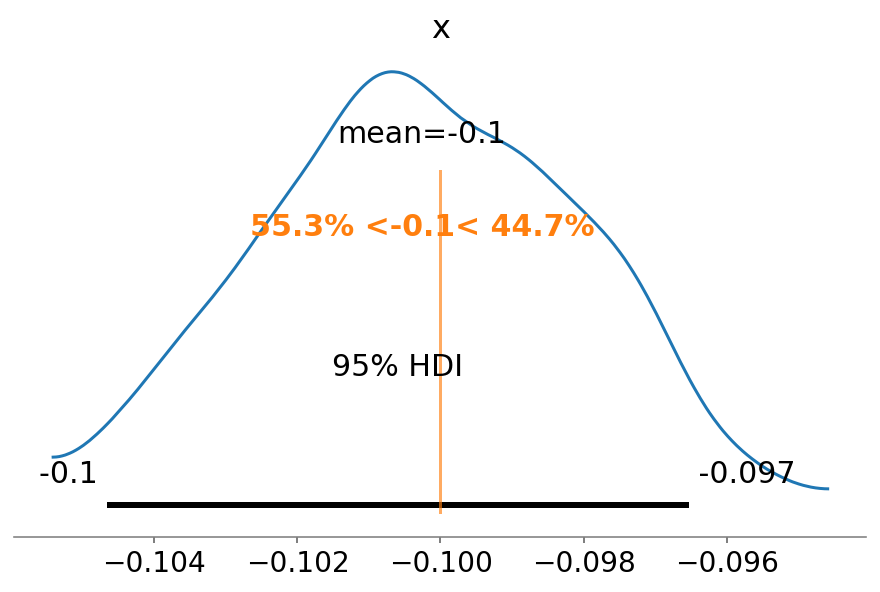

In [34]:
az.plot_posterior(parameters[:,1],hdi_prob = 0.95, ref_val = -0.1)

<AxesSubplot:title={'center':'x'}>

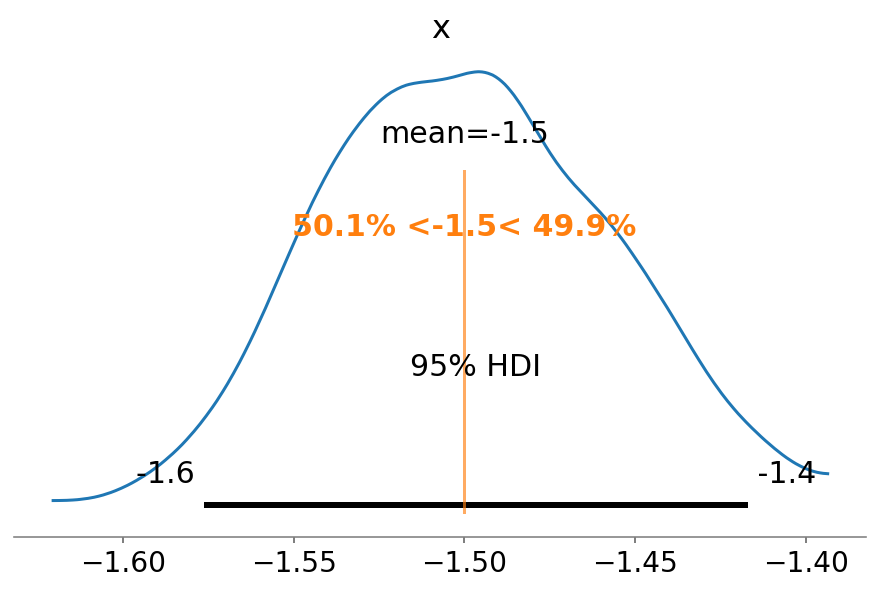

In [35]:
az.plot_posterior(parameters[:,2],hdi_prob = 0.95, ref_val = -1.5)

<AxesSubplot:title={'center':'x'}>

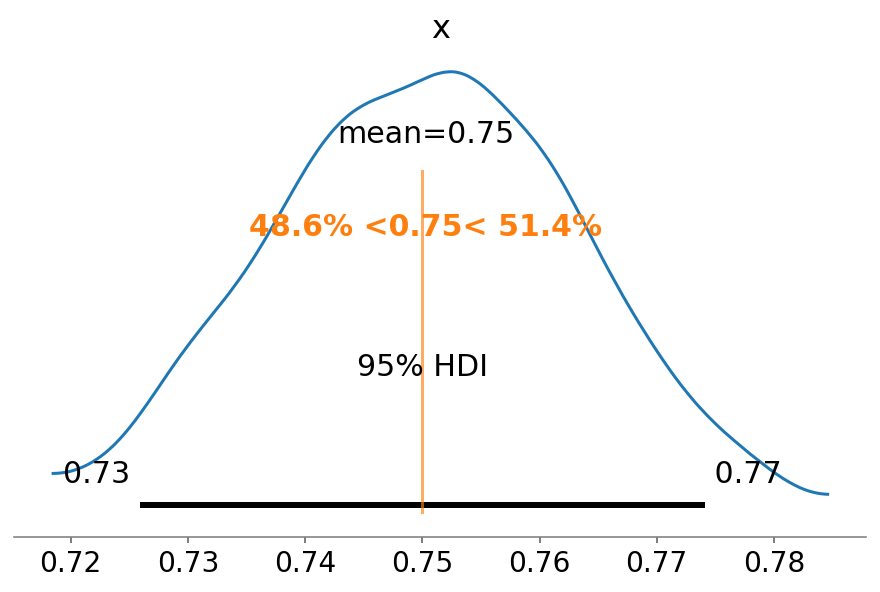

In [37]:
az.plot_posterior(parameters[:,3],hdi_prob = 0.95, ref_val = 0.75)

In [ ]:
##################################################################################################################